In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

path_gold = '/Users/lucaslumertz/Documents/1Programacao/challanges/PLACE v2/data/gold/regioes_promissoras_gold.csv'
df_gold = pd.read_csv(path_gold, sep=';')
df_gold.head()

,nome_do_bairro,tipo,area_km2,qtd_empresas,qtd_pontos_onibus,empresas_por_km2,pontos_onibus_por_km2,potencial_score,categoria_score,latitude,longitude
0,CRISTO REDENTOR,Conjunto Habitacional,0.005,0,305,0.000000,61000.000000,10.00,Ótimo,-19.983318,-44.006399
1,OURO PRETO,Conjunto Habitacional,0.031,5010,91,161612.903226,2935.483871,8.62,Ótimo,-19.934739,-44.003353
2,PUC,Vila,0.004,0,155,0.000000,38750.000000,6.35,Ótimo,-19.920251,-43.994589
3,COPASA,Vila,0.009,0,311,0.000000,34555.555556,5.66,Ótimo,-19.981341,-44.006274
4,TIROL,Conjunto Habitacional,0.030,2526,179,84200.000000,5966.666667,5.22,Ótimo,-19.986141,-44.036326


#### Distribuição das Categorias de Score:

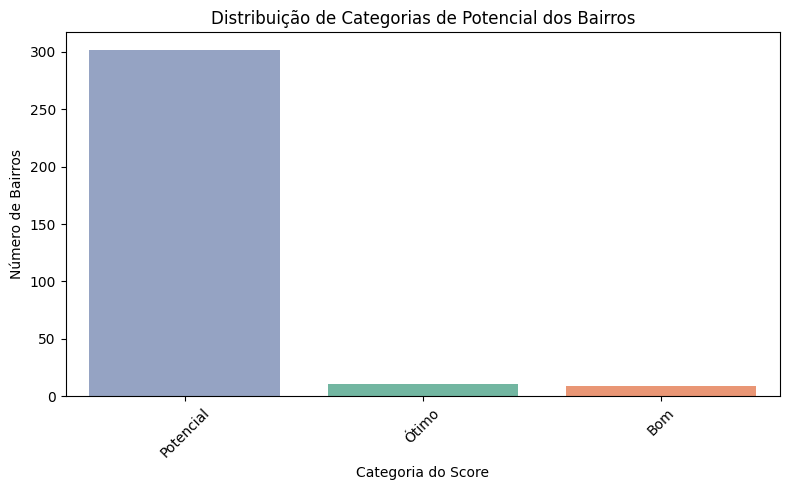

In [2]:
plt.figure(figsize=(8, 5))

sns.countplot(
    data=df_gold,
    x='categoria_score',
    hue='categoria_score',
    palette='Set2',
    order=df_gold['categoria_score'].value_counts().index,
    legend=False
)

plt.title('Distribuição de Categorias de Potencial dos Bairros')
plt.xlabel('Categoria do Score')
plt.ylabel('Número de Bairros')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Top 10 Bairros Mais Promissores de Acordo com o Score:

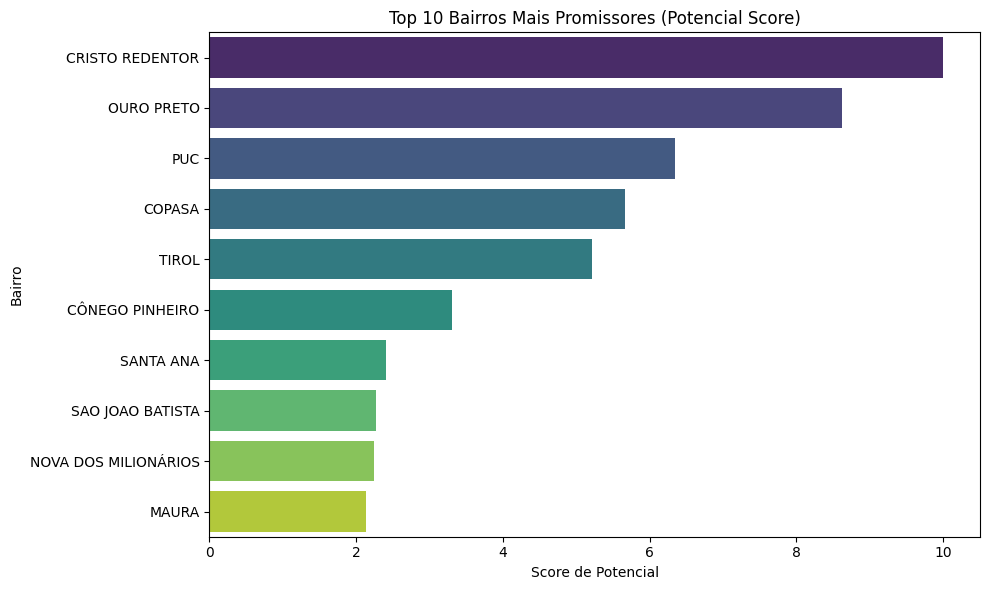

In [3]:
top_n = 10
top_bairros = df_gold.sort_values(by='potencial_score', ascending=False).head(top_n)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=top_bairros,
    x='potencial_score',
    y='nome_do_bairro',
    hue='nome_do_bairro',
    palette='viridis',
    legend=False
)

plt.title(f'Top {top_n} Bairros Mais Promissores (Potencial Score)')
plt.xlabel('Score de Potencial')
plt.ylabel('Bairro')
plt.tight_layout()
plt.show()

#### Mapa Simplificado dos Bairros Promissores:

In [4]:
df_map = df_gold[df_gold['categoria_score'].isin(['Ótimo', 'Bom', 'Potencial', 'Arriscado'])]

cores_personalizadas = {
    "Ótimo": "green",
    "Bom": "blue",
    "Potencial": "gold",
    "Arriscado": "red"
}

fig = px.scatter_map(
    df_map,
    lat="latitude",
    lon="longitude",
    color="categoria_score",
    color_discrete_map=cores_personalizadas,
    hover_name="nome_do_bairro",
    hover_data={
        "potencial_score": True,
        "empresas_por_km2": True,
        "pontos_onibus_por_km2": True,
        "latitude": False,
        "longitude": False
    },
    zoom=11,
    height=600
)

fig.update_traces(marker=dict(size=10))

fig.show()

#### Melhores Bairros com Alta Disponibilidade de Transporte e no máximo 100 Empresas:

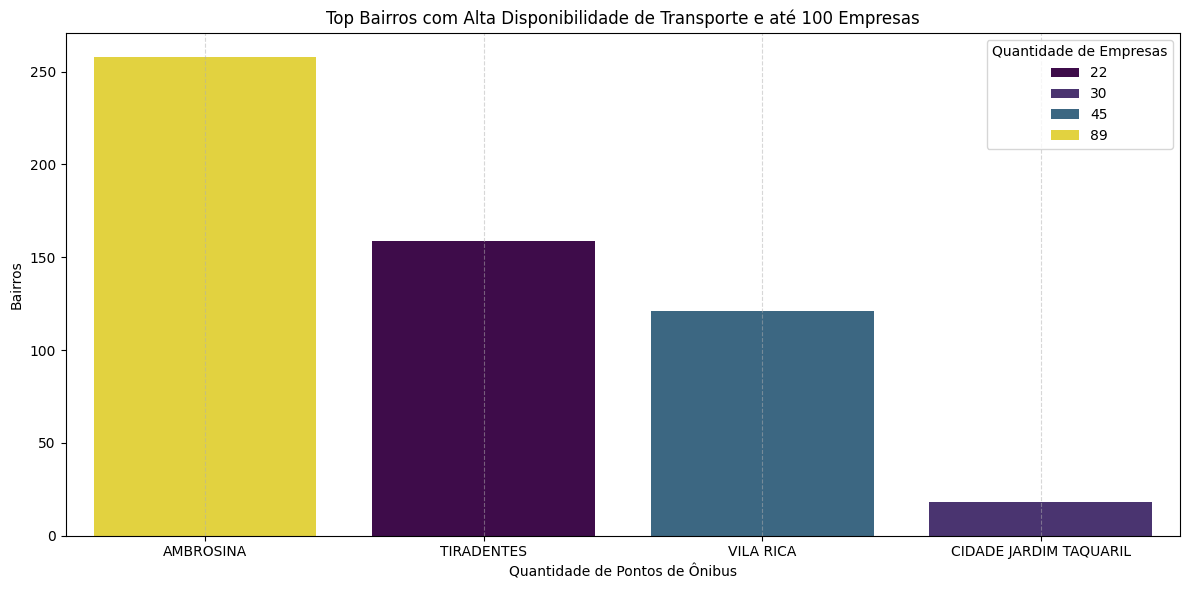

In [5]:
df_filtrado_limite = df_gold[
    (df_gold['qtd_empresas'] >= 10) & (df_gold['qtd_empresas'] <= 100)
]

top_bairros_custom = df_filtrado_limite.sort_values(
    by='qtd_pontos_onibus', ascending=False
).head(10)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=top_bairros_custom,
    y='qtd_pontos_onibus',
    x='nome_do_bairro',
    hue='qtd_empresas',
    palette='viridis'
)

plt.title("Top Bairros com Alta Disponibilidade de Transporte e até 100 Empresas")
plt.xlabel("Quantidade de Pontos de Ônibus")
plt.ylabel("Bairros")
plt.legend(title="Quantidade de Empresas")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

#### Distribuição de Bairros por Nível de Disponibilidade de Transporte e Ocupação:

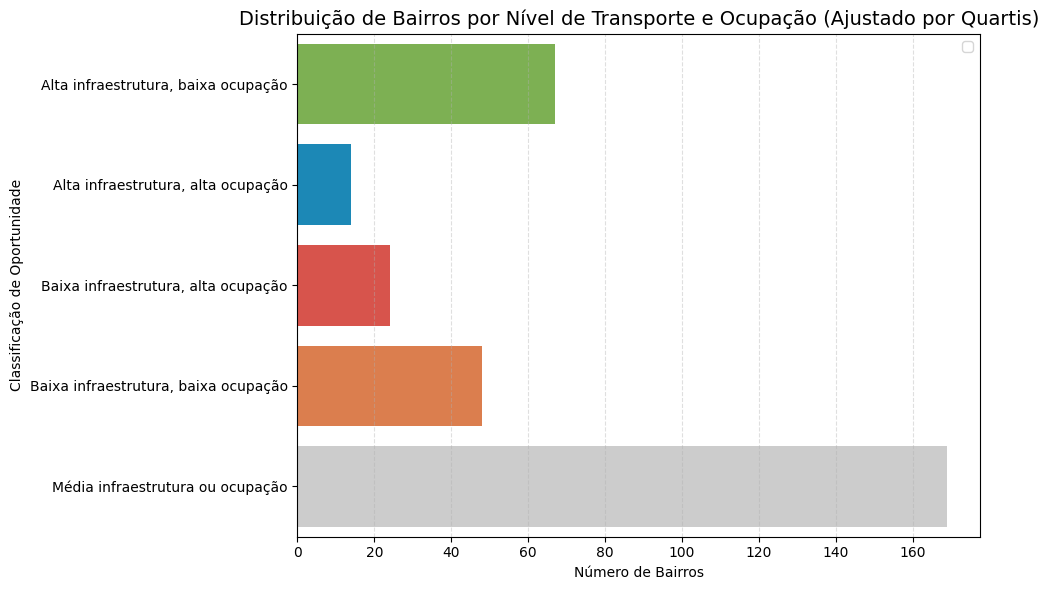

In [ ]:
# === Quartis de referência para empresas e pontos de ônibus por km² ===
q_empresas = df_gold['empresas_por_km2'].quantile([0.25, 0.75])
q_onibus = df_gold['pontos_onibus_por_km2'].quantile([0.25, 0.75])

# === Função para classificar os bairros ===
def classificar_quadrante(empresas, onibus):
    if onibus >= q_onibus[0.75]:
        if empresas >= q_empresas[0.75]:
            return 'Alta infraestrutura, alta ocupação'
        elif empresas <= q_empresas[0.25]:
            return 'Alta infraestrutura, baixa ocupação'
    elif onibus <= q_onibus[0.25]:
        if empresas >= q_empresas[0.75]:
            return 'Baixa infraestrutura, alta ocupação'
        elif empresas <= q_empresas[0.25]:
            return 'Baixa infraestrutura, baixa ocupação'
    return 'Média infraestrutura ou ocupação'

# === Aplica a classificação ao DataFrame ===
df_gold['quadrante'] = df_gold.apply(
    lambda row: classificar_quadrante(row['empresas_por_km2'], row['pontos_onibus_por_km2']),
    axis=1
)

# === Contagem dos bairros por quadrante ===
quantidade_por_quadrante = df_gold['quadrante'].value_counts().reset_index()
quantidade_por_quadrante.columns = ['Quadrante', 'Quantidade']

# === Define a ordem desejada dos quadrantes ===
ordem_quadrantes = [
    'Alta infraestrutura, baixa ocupação',
    'Alta infraestrutura, alta ocupação',
    'Baixa infraestrutura, alta ocupação',
    'Baixa infraestrutura, baixa ocupação',
    'Média infraestrutura ou ocupação'
]

# Ordena com base nos quadrantes definidos
quantidade_por_quadrante['Quadrante'] = pd.Categorical(
    quantidade_por_quadrante['Quadrante'],
    categories=ordem_quadrantes,
    ordered=True
)

quantidade_por_quadrante = quantidade_por_quadrante.sort_values('Quadrante', ascending=False)

plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=quantidade_por_quadrante,
    y='Quadrante',
    x='Quantidade',
    hue='Quadrante',
    dodge=False,
    palette={
        'Alta infraestrutura, alta ocupação': '#0392cf',
        'Alta infraestrutura, baixa ocupação': '#7bc043',
        'Baixa infraestrutura, alta ocupação': '#ee4035',
        'Baixa infraestrutura, baixa ocupação': '#f37736',
        'Média infraestrutura ou ocupação': '#cccccc'
    }
)

handles, labels = barplot.get_legend_handles_labels()
barplot.legend(handles[:5], ordem_quadrantes)

plt.title("Distribuição de Bairros por Nível de Transporte e Ocupação (Ajustado por Quartis)", fontsize=14)
plt.xlabel("Número de Bairros")
plt.ylabel("Classificação de Oportunidade")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()